**Importing dependencies**

In [1]:
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Literal
import pandas as pd
import time
import os

from fleetrl.fleet_env.fleet_environment import FleetEnv
from fleetrl.benchmarking.benchmark import Benchmark
from fleetrl.benchmarking.uncontrolled_charging import Uncontrolled
from fleetrl.benchmarking.distributed_charging import DistributedCharging
from fleetrl.benchmarking.night_charging import NightCharging
from fleetrl.benchmarking.linear_optimization import LinearOptimization

from fleetrl.agent_eval.evaluation import Evaluation
from fleetrl.agent_eval.basic_evaluation import BasicEvaluation

from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback, BaseCallback
from stable_baselines3.common.logger import HParam

from pink import PinkActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise, NormalActionNoise

(c) Copyright 2023 Enzo Alexander Cording - https://github.com/EnzoCording - GNU GPL v3.0

RL is a computational approach to learning via interaction with an environment. It
is a field of machine learning that can tackle complex problems by modelling them as
decision-making processes. In RL, an agent interacts with an environment and seeks
to achieve the optimal outcome by taking the right actions at the right time. Just like in
the real world, there can be uncertainty or delayed consequences that require strategic
behaviour. Trade-offs might have to be made between an immediate reward and a
potential reward in the future. When an agent is first introduced to its environment, it
does not possess the knowledge to evaluate its actions. It must therefore explore and
learn through trial and error, as well as understand that some actions might only be
beneficial at a later point in time

This pipeline walks through the entire functionalities of FleetRL

1) Creating a custom use-case
    - Updating your data path
    - Changing environment settings if needed
    - Generating your own vehicle schedules
2) Training an RL agent
3) Building benchmark charging strategies
4) Comparing the RL agent to the benchmarks

This code could also be run in a .py file. Then, the code should be wrapped in:

    if __name__ == "__main__":
        #code here

Environment: Simulation in which the algorithm takes actions, e.g. Mario Kart, or a Chess game
Agent: The algorithm which learns how to make the best decisions over time
Action: The decisions the agent takes
Reward: Feedback signal from the environment, based on the agent's actions
Policy: Strategy to get the best reward possible
State: Representation of the environment, e.g. a frame of Mario Kart, the current Chess board

In this tutorial, we will be looking at a truck with the following parameters:

- 600 kWh BESS
- On board charger max power: 250 kW
- Charging efficiency: 91%
- Discharging efficiency: 91%
- EV charger power: 120 kW

More important info:
- Model time resolution: 15 minutes
- Energy calculations are from the perspective of the EV charger
- 10 ct/kWh fixed markup
- 50% electricity tax
- 25% deducted from energy fed in to the grid

Let's have a look at what a state looks like in FleetRL:

In [2]:
env = FleetEnv("./tutorial.json")
env.reset()

Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...


(array([ 6.0119551e-01,  3.3750000e+01,  1.0825500e+02,  1.0504500e+02,
         9.7544998e+01,  9.3375000e+01,  8.7675003e+01,  8.4165001e+01,
         7.9500000e+01,  7.4324997e+01,  6.7769997e+01,  4.6627499e+01,
         4.5022499e+01,  4.1272499e+01,  3.9187500e+01,  3.6337502e+01,
         3.4582500e+01,  3.2250000e+01,  2.9662500e+01,  2.6385000e+01,
         3.6179073e+01,  3.6638813e+01,  3.6546093e+01,  3.6987045e+01,
         3.6821480e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  8.5000002e-01,
         2.4880446e-01,  1.3670576e+00,  5.0000000e+00,  1.2000000e+02,
         5.0000000e+02,  4.6382092e+02,  1.0000000e+00,  5.0000000e-01,
         8.6602539e-01, -9.7492790e-01, -2.2252093e-01, -9.6592581e-01,
         2.5881904e-01], dtype=float32),
 {})

The state is represented by the numpy array. It tells the agent what is currently going on with the EVs, the building load, spot price, etc.

This is what the array contains - you can find this code under utils/observation/observer_bl_pv.py:

    obs = {
        "soc": list(soc),  # state of charge
        "hours_left": list(hours_left),  # hours left at the charger
        "price": list(price),  # price for charging
        "tariff": list(tariff),  # price received when discharging
        "building_load": list(building_load),  # building load in kW
        "pv": list(pv),  # pv power in kW
        "there": list(there),  # boolean, is the car i there or not
        "target_soc": list(target_soc),  # target soc of car i
        "charging_left": list(charging_left),  # charging % left
        "hours_needed": list(hours_needed),  # hours needed to get to target soc
        "laxity": list(laxity),  # laxity factor
        "evse_power": list(evse_power),  # evse power in kW
        "grid_cap": list(grid_cap),  # grid capacity
        "avail_grid_cap": list(avail_grid_cap),  # available grid capacity
        "possible_avg_action": list(possible_avg_action_per_car),  # possible avg action without overloading
        "month_sin": month_sin,  # month in sin, and so on
        "month_cos": month_cos,
        "week_sin": week_sin,
        "week_cos": week_cos,
        "hour_sin": hour_sin,
        "hour_cos": hour_cos
    }

Now let's see what happens if we take an action in the environment.
Actions can range from -1 to 1 - corresponding to the % of kW of the charger

In [3]:
env.step([1])

Timestep: 2021-01-02 19:00:00
Total price with fees: 0.108 €/kWh
Spot: 0.062 €/kWh
Tariff: 0.046627499999999995 €/kWh
SOC: [0.647], Time left: [33.75] hours
Action taken: [1]
Actual charging energy: 30.0 kWh
Logging energy: 30.0 kWh
Charging cost/revenue: -3.248 €
SoH: [1.]
--------------------------
Reward signal: -17.415
---------




(array([ 6.4669555e-01,  3.3500000e+01,  1.0825500e+02,  1.0504500e+02,
         9.7544998e+01,  9.3375000e+01,  8.7675003e+01,  8.4165001e+01,
         7.9500000e+01,  7.4324997e+01,  6.7769997e+01,  4.6627499e+01,
         4.5022499e+01,  4.1272499e+01,  3.9187500e+01,  3.6337502e+01,
         3.4582500e+01,  3.2250000e+01,  2.9662500e+01,  2.6385000e+01,
         3.6179073e+01,  3.6638813e+01,  3.6546093e+01,  3.6987045e+01,
         3.6821480e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  8.5000002e-01,
         2.4880446e-01,  1.3670576e+00,  5.0000000e+00,  1.2000000e+02,
         5.0000000e+02,  4.6382092e+02,  1.0000000e+00,  5.0000000e-01,
         8.6602539e-01, -9.7492790e-01, -2.2252093e-01, -9.6592581e-01,
         2.5881904e-01], dtype=float32),
 -17.414622149287453,
 False,
 False,
 {})

As you can see, you just sent a charging signal with 120 kW over 15 minutes, totalling 30 kWh and the SOC went from 0.6012 to 0.647.
That cost 2.52€ and since you spent money, you get a negative reward.

In [4]:
new_soc = 30 * 0.91 / 600 + 0.6012
price_with_fees = 0.084
energy_drawn_at_charger = 30
cost = energy_drawn_at_charger * price_with_fees
cost

2.52

Now try discharging the EV:

In [5]:
env.step([-1])

Timestep: 2021-01-02 19:15:00
Total price with fees: 0.108 €/kWh
Spot: 0.062 €/kWh
Tariff: 0.046627499999999995 €/kWh
SOC: [0.597], Time left: [33.5] hours
Action taken: [-1]
Actual charging energy: -30.0 kWh
Logging energy: -30.0 kWh
Charging cost/revenue: 1.273 €
SoH: [1.]
--------------------------
Reward signal: 7.958
---------




(array([ 5.9669554e-01,  3.3250000e+01,  1.0825500e+02,  1.0504500e+02,
         9.7544998e+01,  9.3375000e+01,  8.7675003e+01,  8.4165001e+01,
         7.9500000e+01,  7.4324997e+01,  6.7769997e+01,  4.6627499e+01,
         4.5022499e+01,  4.1272499e+01,  3.9187500e+01,  3.6337502e+01,
         3.4582500e+01,  3.2250000e+01,  2.9662500e+01,  2.6385000e+01,
         3.6179073e+01,  3.6638813e+01,  3.6546093e+01,  3.6987045e+01,
         3.6821480e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  8.5000002e-01,
         2.4880446e-01,  1.3670576e+00,  5.0000000e+00,  1.2000000e+02,
         5.0000000e+02,  4.6382092e+02,  1.0000000e+00,  5.0000000e-01,
         8.6602539e-01, -9.7492790e-01, -2.2252093e-01, -9.6592581e-01,
         2.5881904e-01], dtype=float32),
 7.958061074643725,
 False,
 False,
 {})

This time, the SOC went down to 0.597, as we take out 30 kWh from the battery, but only a portion of that arrives as useful energy at the charger. Selling at the spot market, we receive 1.273€ and thus a positive reward

In [6]:
new_soc = 0.647 - 30/600
useful_energy = 30*0.91
deduction = 0.25
revenue = useful_energy * (0.062 * (1-deduction))
revenue  # difference due to rounding of spot price

1.26945

Penalties are given out for invalid actions, e.g. overcharging the battery:

In [7]:
for _ in range(10):
    env.step([10])

Overcharged, penalty of: -0.2
Timestep: 2021-01-02 19:30:00
Total price with fees: 0.108 €/kWh
Spot: 0.062 €/kWh
Tariff: 0.046627499999999995 €/kWh
SOC: [0.85], Time left: [33.25] hours
Action taken: [10]
Actual charging energy: 167.014 kWh
Logging energy: 167.014 kWh
Charging cost/revenue: -18.08 €
SoH: [1.]
--------------------------
Grid connection of 500 kW has been overloaded: 736.1790730600001 kW. Penalty: -700.0
Reward signal: -797.149
---------


Overcharged, penalty of: -0.2
Timestep: 2021-01-02 19:45:00
Total price with fees: 0.108 €/kWh
Spot: 0.062 €/kWh
Tariff: 0.046627499999999995 €/kWh
SOC: [0.85], Time left: [33.0] hours
Action taken: [10]
Actual charging energy: 0.0 kWh
Logging energy: 0.0 kWh
Charging cost/revenue: 0.0 €
SoH: [1.]
--------------------------
Grid connection of 500 kW has been overloaded: 736.1790730600001 kW. Penalty: -700.0
Reward signal: -700.2
---------


Overcharged, penalty of: -0.2
Timestep: 2021-01-02 20:00:00
Total price with fees: 0.105 €/kWh
S

As you can see, over charging the battery has a small penalty, but overloading the grid connection and potentially blowing a fuse has much larger implications and thus a much bigger penalty. The agent learns over time to avoid grid overloading at all costs, and then focuses on minimising small penalties such as this one. Penalties are also incurred for letting the car leave without reaching target SOC of 85%:

In [8]:
for _ in range(31*4):
    env.step([-1])

Timestep: 2021-01-02 22:00:00
Total price with fees: 0.093 €/kWh
Spot: 0.052 €/kWh
Tariff: 0.0391875 €/kWh
SOC: [0.8], Time left: [30.75] hours
Action taken: [-1]
Actual charging energy: -30.0 kWh
Logging energy: -30.0 kWh
Charging cost/revenue: 1.07 €
SoH: [1.]
--------------------------
Reward signal: 7.215
---------


Timestep: 2021-01-02 22:15:00
Total price with fees: 0.093 €/kWh
Spot: 0.052 €/kWh
Tariff: 0.0391875 €/kWh
SOC: [0.75], Time left: [30.5] hours
Action taken: [-1]
Actual charging energy: -30.0 kWh
Logging energy: -30.0 kWh
Charging cost/revenue: 1.07 €
SoH: [1.]
--------------------------
Reward signal: 7.215
---------


Timestep: 2021-01-02 22:30:00
Total price with fees: 0.093 €/kWh
Spot: 0.052 €/kWh
Tariff: 0.0391875 €/kWh
SOC: [0.7], Time left: [30.25] hours
Action taken: [-1]
Actual charging energy: -30.0 kWh
Logging energy: -30.0 kWh
Charging cost/revenue: 1.07 €
SoH: [1.]
--------------------------
Reward signal: 7.215
---------


Timestep: 2021-01-02 22:45:00
T

A car left the station without reaching the target SoC. Penalty: -498.949
Reward signal: -503.899

Now that you have got a hang of the basics, let's configure our own use-case and train an agent on it.

**Creating a custom use-case**
Go through this step by step and check the documentation if needed. The docs specify what type of input data is required, what format it should be in, etc.
The code below is commented to provide the most essential information.

Docs: fleetrl.readthedocs.io

**General settings**
Under general settings, you can adjust how many vehicles to optimize for, whether you would like to create new schedules how long the episodes should be, etc.
There is a pre-trained agent for the 1-EV environments. So you can train your own agent and compare its performance. There are also benchmarks of uncontrolled charging, night charging, and linear optimisation to compare against deterministic charging strategies that are being used today.

Some more important concepts:

Episode: One iteration of the agent through the environment, until a final state is reached or the time limit expires - e.g. a game of chess or in this case, a certain number of consecutive hours of managing the EV charging process

Training: When an episode is done, the agent takes the collected experience, learns from it and starts a new episode. This process can go on as long as you like. Typically, you observe the agent's performance and interrupt training as soon as performance begins to pleateau 

In [9]:
# define fundamental parameters
# data path to inputs folder with schedule csv, prices, load, pv, etc.
input_data_path: str = "inputs"  # path to input folder, starting from the location of this jupyter notebook
time_now = time.time()
run_name: str = f"Test_run_custom_{time_now}"  # Change this name or make it dynamic, e.g. with a timestamp
n_train_steps = 48  # number of hours in a training episode
n_eval_steps = 48  # number of hours in one evaluation episode
n_eval_episodes = 1  # number of episodes for evaluation
n_evs = 1  # number of evs
n_envs = 2  # number of environment running in parallel (speeds up training, 1 env = 1 CPU)
time_steps_per_hour = 4  # temporal resolution of the simulation (quarter-hourly)
use_case: str = "custom"  # for file name - lmd=last mile delivery, by default can insert "lmd", "ct", "ut", "custom"
custom_schedule_name = "1_lkw.csv"  # name for custom schedule if you have generated one. If you want to generate one this time, this field will be ignored
scenario: Literal["arb", "tariff"] = "arb"  # arbitrage or tariff. Arbitrage allows for bidirectional spot trading, no fees. Tariff models commercial tariff with grid fees, electricity tax, etc.
gen_new_schedule = False  # generate a new schedule - refer to schedule generator documentation and adjust statistics in config.json
gen_new_test_schedule = False  # generate a new schedule for agent testing
end_cutoff = 330  # the dataset has 365 days. We want to only train on 1 month of data in this lab, so we remove the last 11 months

**Training settings**
These more low-level settings allow you to change training-related parameters. Refer to the documentation of FleetRL and stable-baselines3 for further details. Observations are by default normalized within SB3, due to their rolling average normalization. You can also conduct absolute normalization via FleetRL. (In that case, the observation of electricity price is divided by the global maximum electricity price in the dataset). Normalization is common practice when working with neural networks for numeric stability, faster training process, and because neural network optimisers work best with normalized numbers.

Adapt total training steps and saving interval for a full run.

In [10]:
# training parameters
norm_obs_in_env = False  # normalize observations within FleetRL (max, min normalization)
vec_norm_obs = True  # normalize observations in SB3 (rolling normalization)
vec_norm_rew = True  # normalize rewards in SB3 (rolling normalization)

# Total steps should be sep to 1e6 or 5e6 for a full run. Check tensorboard for stagnating reward signal and stop training at some point to avoid overfit
total_steps = int(5e3)  # total training time steps

# Specifies how often you want to make an intermediate artifact. For a full run, I recommend every 50k - 100k steps, so you can backtrack for best model
saving_interval = 5e2  # interval for saving the model

**Parameters for environment object creation**
Further settings can be adjusted below, view the comments and docs for more detailed explanations.
Most important:
- Episode length: How long an episode is in hours - at least 36 hours are recommended so the agent always sees one passage of a night for night charging
- include_building, include_pv, include_price: These adjust the shape of the observations to make the problem simpler or more complex
- price_lookahead, bl_pv_lookahead: These dictate how much knowledge into the future the agent has on price, building load and PV in hours
- Time picker: Use random during training: This way, a new episode always starts at a random point in the dataframe
- Deg_emp: For simple degradation, set to True
- Ignore_x_reward: Set accordingly with Include_x... or deactivate certain parts of the reward function to adjust problem complexity

In [11]:
# environment arguments - adjust settings if necessary
# additional settings can be changed in the config files
env_config = {"data_path": input_data_path,
              # Specify file names: there is a naming convention for default files, otherwise, custom name is used
              "schedule_name": (str(n_evs) + "_" + str(use_case) + ".csv") if use_case != "custom" else custom_schedule_name,
              "building_name": "load_" + str(use_case) + ".csv" if use_case != "custom" else "load_lmd.csv",
              "pv_name": None,  # if separate file for PV inputs, specify here, otherwise, uses "PV" column in building_name
              # Define use case
              "use_case": use_case,
              # Change observation space
              "include_building": True,  # False removes building load from Observation
              "include_pv": True,  # False removes PV from Observation
              "include_price": True,  # False removes electricity prices from Observation
              "price_lookahead": 8,  # Hours seen into the future
              "bl_pv_lookahead": 4,  # Hours seen into the future
              "time_steps_per_hour": 4,  # Time resolution
              # Specify time picker: "eval", "static", or "random" are implemented
              "time_picker": "random",  # Pick a random starting day in the schedule dataframe
              "end_cutoff": end_cutoff,
              # Pick degradation methodology: True sets empirical degradation from experimental degradation
              "deg_emp": False,  # empirical degradation calculation
              # Shape reward function
              "ignore_price_reward": False,  # True sets price-related reward coefficient to 0
              "ignore_invalid_penalty": False,  # True ignores penalties on invalid actions (charging an empty spot)
              "ignore_overcharging_penalty": False,  # True ignores penalties on charging signals above target SOC
              "ignore_overloading_penalty": False,  # True ignores grid connection overloading penalty
              # Set episode length during training
              "episode_length": n_train_steps,  # in hours
              # Additional parameters
              "normalize_in_env": norm_obs_in_env,  # Conduct normalization within FleetRL.
              "verbose": 0,  # Print statements, can slow down FPS
              "aux": True,  # Include auxiliary data (recommended). Check documentation for more information.
              "log_data": False,  # Log data (Makes most sense for evaluation runs)
              "calculate_degradation": True,  # Calculate SOH degradation (Can slow down FPS)
              # Target SOC
              "target_soc": 0.85,  # Signals that would charge above target SOC are clipped.
              # settings regarding the generation of evs
              "gen_schedule": gen_new_schedule,  # generate a new schedule
              "gen_start_date": "2021-01-01 00:00",  # if new schedule, start date
              "gen_end_date": "2021-12-31 23:59:59",  # if new schedule, end date
              "gen_name": "my_custom_schedule.csv",  # name of newly generated schedule
              "gen_n_evs": 1,  # number of EVs in new schedule, per EV it takes ca. 10-20 min.
              # seed for random number generation
              "seed": 42,  # Seed for RNG - can be set to None so always random
              # if you are comparing cars with different bess sizes, use this to norm their reward function range
              "max_batt_cap_in_all_use_cases": 600,
              "init_battery_cap": 600,
              # initial state of health of the battery
              "init_soh": 1.0,
              "min_laxity": 1.75,
              "obc_max_power": 250,
              "real_time": False,
              # custom schedule timing settings, mean and standard deviation
              "custom_weekday_departure_time_mean": 7,
              "custom_weekday_departure_time_std": 1,
              "custom_weekday_return_time_mean": 19,
              "custom_weekday_return_time_std": 1,
              "custom_weekend_departure_time_mean": 9,
              "custom_weekend_departure_time_std": 1.5,
              "custom_weekend_return_time_mean": 17,
              "custom_weekend_return_time_std": 1.5,
              "custom_earliest_hour_of_departure": 3,
              "custom_latest_hour_of_departure": 11,
              "custom_earliest_hour_of_return": 12,
              "custom_latest_hour_of_return": 23,
              # custom distance settings
              "custom_weekday_distance_mean": 300,
              "custom_weekday_distance_std": 25,
              "custom_weekend_distance_mean": 150,
              "custom_weekend_distance_std": 25,
              "custom_minimum_distance": 20,
              "custom_max_distance": 400,
              # custom consumption data for vehicle
              "custom_consumption_mean": 1.3,
              "custom_consumption_std": 0.167463672468669,
              "custom_minimum_consumption": 0.3,
              "custom_maximum_consumption": 2.5,
              "custom_maximum_consumption_per_trip": 500,
              # custom ev-related settings
              "custom_ev_charger_power_in_kw": 120,
              "custom_ev_battery_size_in_kwh": 600,
              "custom_grid_connection_in_kw": 500
              }

# commercial tariff scenario, fixed fee on spot price (+10 ct/kWh, and a 50% mark-up)
# Feed-in tariff orientates after PV feed-in, with 25% deduction
if scenario == "tariff":
    env_config["spot_markup"] = 10
    env_config["spot_mul"] = 1.5
    env_config["feed_in_ded"] = 0.25
    env_config["price_name"] = "spot_2021_new.csv"
    env_config["tariff_name"] = "fixed_feed_in.csv"

# arbitrage scenario, up and down prices are spot price, no markups or taxes
elif scenario == "arb":
    env_config["spot_markup"] = 0
    env_config["spot_mul"] = 1
    env_config["feed_in_ded"] = 0
    env_config["price_name"] = "spot_2021_new.csv"
    env_config["tariff_name"] = "spot_2021_new_tariff.csv"

**Environment object creation**
Vec_Env are created to enable multi-processing.

Train_vec_env: For agent training
Eval_vec_env: For agent evaluation during training on same csv file (70% training data, 30% evaluation data)

In [12]:
env_kwargs = {"env_config": env_config}

train_vec_env = make_vec_env(FleetEnv,
                             n_envs=n_envs,
                             vec_env_cls=SubprocVecEnv,
                             env_kwargs=env_kwargs,
                             seed=env_config["seed"])

train_norm_vec_env = VecNormalize(venv=train_vec_env,
                                  norm_obs=vec_norm_obs,
                                  norm_reward=vec_norm_rew,
                                  training=True,
                                  clip_reward=10.0)

env_config["time_picker"] = "eval"

if gen_new_schedule:
    env_config["gen_schedule"] = False
    env_config["schedule_name"] = env_config["gen_name"]

env_kwargs = {"env_config": env_config}

eval_vec_env = make_vec_env(FleetEnv,
                            n_envs=n_envs,
                            vec_env_cls=SubprocVecEnv,
                            env_kwargs=env_kwargs,
                            seed=env_config["seed"])

eval_norm_vec_env = VecNormalize(venv=eval_vec_env,
                                  norm_obs=vec_norm_obs,
                                  norm_reward=vec_norm_rew,
                                  training=True,
                                  clip_reward=10.0)

This creates a schedule for testing the trained agents on unseen data.
It is recommended to generate a testing schedule along with a newly generated training schedule.

In [13]:
if gen_new_test_schedule:
    # generate an evaluation schedule
    test_sched_name = env_config["gen_name"]
    if not test_sched_name.endswith(".csv"):
        test_sched_name = test_sched_name + "_test" + ".csv"
    else:
        test_sched_name = test_sched_name.strip(".csv")
        test_sched_name = test_sched_name + "_test" + ".csv"

    env_config["gen_schedule"] = True
    env_config["gen_name"] = test_sched_name

    env_kwargs = {"env_config": env_config}

    test_vec_env = make_vec_env(FleetEnv,
                                n_envs=1,
                                vec_env_cls=SubprocVecEnv,
                                env_kwargs=env_kwargs,
                                seed=env_config["seed"])

    env_config["gen_schedule"] = False
    env_config["schedule_name"] = test_sched_name

    env_kwargs = {"env_config": env_config}

test_vec_env = make_vec_env(FleetEnv,
                            n_envs=n_envs,
                            vec_env_cls=SubprocVecEnv,
                            env_kwargs=env_kwargs,
                            seed=env_config["seed"])

test_norm_vec_env = VecNormalize(venv=test_vec_env,
                                 norm_obs=vec_norm_obs,
                                 norm_reward=vec_norm_rew,
                                 training=True,
                                 clip_reward=10.0)

Callbacks are regularly called during training and enable useful functionalities such as logging or progress reporting. View SB3 docs for further information. Note that wandb callbacks are possible with SB3.

Eval callback triggers an evaluation at fixed intervals
HyperParamCallback logs hyperparameters, also visible in TensorBoard
ProgressBar indicated progress of an epoch

In [14]:
eval_callback = EvalCallback(eval_env=eval_norm_vec_env,
                             warn=True,
                             verbose=1,
                             deterministic=True,
                             eval_freq=max(10000 // n_envs, 1),
                             n_eval_episodes=5,
                             render=False,
                             )

class HyperParamCallback(BaseCallback):
    """
    Saves hyperparameters and metrics at start of training, logging to tensorboard
    """

    def _on_training_start(self) -> None:
        hparam_dict = {
            "algorithm": self.model.__class__.__name__,
            "learning rate": self.model.learning_rate,
            "gamma": self.model.gamma,
        }

        metric_dict = {
            "rollout/ep_len_mean": 0,
            "train/value_loss": 0.0,
        }

        self.logger.record(
            "hparams",
            HParam(hparam_dict, metric_dict),
            exclude=("stdout", "log", "json", "csv")
        )

    def _on_step(self) -> bool:
        return True

progress_bar = ProgressBarCallback()

## wandb callback possible, check documentation of SB3 and wandb

In [15]:
hyperparameter_callback = HyperParamCallback()

If you use TD3, pink action noise is said to improve performance
If you use PPO, this is not used

In [16]:
# model-related settings
n_actions = train_norm_vec_env.action_space.shape[-1]
param_noise = None
noise_scale = 0.1
seq_len = n_train_steps * time_steps_per_hour
action_noise = PinkActionNoise(noise_scale, seq_len, n_actions)

You can choose to create your own agent of load an existing one. A pretrained PPO agent exists for a 1 EV environment.

In [17]:
load_existing_agent = True
if load_existing_agent:
    model = PPO.load(path="./rl_agents/trained_agents/LMD_arbitrage_1e6_steps_example_agent/PPO-fleet_LMD_2021_arbitrage_PPO_mul3.zip", env=train_norm_vec_env)

If you want to use a loaded agent, you can skip the next 5 cells below

In [18]:
if not load_existing_agent:
    model = PPO(policy="MlpPolicy",
                verbose=env_config["verbose"], # setting verbose to 0 can introduce performance increases in jupyterlab environments
                env=train_norm_vec_env,
                tensorboard_log="./rl_agents/trained_agents/tb_log")

# might introduce performance increases
            # gamma=0.99,
            # learning_rate=0.0005,
            # batch_size=128,
            # n_epochs=8,
            # gae_lambda=0.9,
            # clip_range=0.2,
            # clip_range_vf=None,
            # normalize_advantage=True,
            # ent_coef=0.0008,
            # vf_coef=0.5,
            # max_grad_norm=0.5,
            # n_steps=2048)

In [19]:
# NOTE: make the Notebook trusted
%reload_ext tensorboard
%tensorboard --logdir ./rl_agents/trained_agents/tb_log --port 6006 --bind_all

In [20]:
if not load_existing_agent:
    comment = run_name
    time_now = int(time.time())
    trained_agents_dir = f"./rl_agents/trained_agents/vec_PPO_{time_now}_{run_name}"
    logs_dir = f"{trained_agents_dir}/logs/"
    
    if not os.path.exists(trained_agents_dir):
        os.makedirs(trained_agents_dir)
    
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)

In [21]:
# model training
# models are saved in a specified interval: once with unique step identifiers
# model and the normalization metrics are saved as well, overwriting the previous file every time
if not load_existing_agent:
    for i in range(0, int(total_steps / saving_interval)):
        print(f"iteration: {i}")
        model.learn(total_timesteps=saving_interval,
                    reset_num_timesteps=False,
                    tb_log_name=f"PPO_{time_now}_{comment}",
                    callback=[eval_callback, hyperparameter_callback, progress_bar])
    
        model.save(f"{trained_agents_dir}/{saving_interval * i}")
    
        # Don't forget to save the VecNormalize statistics when saving the agent
        tmp_dir = f"{trained_agents_dir}/tmp/"
        model_path = tmp_dir + f"PPO-fleet_{comment}_{time_now}"
        model.save(model_path)
        stats_path = os.path.join(tmp_dir, f"vec_normalize-{comment}_{time_now}.pkl")
        train_norm_vec_env.save(stats_path)

Agent evaluation
- Sets the time_picker to static, so an evaluation always starts at the same point in time
- Usually at the beginning of the year and then runs for a long time, e.g. a whole year to test the agent's ability to handle large amounts of unseen data
- Make sure that the environment passed to the trained agent includes the unseen schedule
- For that you should use test_norm_vec_env with the _test.csv schedule

- Data is logged to be used for data analytics later. Every datapoint during the evaluation is tracked at every timestep

In [22]:
# environment arguments for evaluation
env_config["time_picker"] = "static"  # Pick a random starting day in the schedule dataframe
env_config["log_data"] = True,  # Log data (Makes most sense for evaluation runs)

env_kwargs = {"env_config": env_config}

Creation of Evaluation object

In [23]:
eval: Evaluation = BasicEvaluation(n_steps=n_eval_steps,
                                   n_evs=n_evs,
                                   n_episodes=n_eval_episodes,
                                   n_envs=1)

- Use this is you are using a loaded agent. Otherwise, skip this cell
- If you have just trained an agent, stats_path and model_path have been automatically defined

In [24]:
if load_existing_agent:
    stats_path = "./rl_agents/trained_agents/LMD_arbitrage_1e6_steps_example_agent/vec_normalize-LMD_2021_arbitrage_PPO_mul3.pkl"
    model_path = "./rl_agents/trained_agents/LMD_arbitrage_1e6_steps_example_agent/PPO-fleet_LMD_2021_arbitrage_PPO_mul3.zip"

Saves the log from agent evaluation

In [25]:
rl_log = eval.evaluate_agent(env_kwargs=env_kwargs, norm_stats_path=stats_path, model_path=model_path, seed=env_config["seed"])

-70.073181


The cells below define benchmarks and run them, saving the logs in the same way as RL evaluation
- Uncontrolled charging: Plug in on arrival
- LP: Linear-programming model - requires an LP solver (on Windows you might run into trouble when doing pip install glpk or similar due to C++ or MSVC. In that case you can try using a Conda environment for the repo and it should work.)
  - Gurobi requires a license to be specified
- Dist: Distributed charging, charges such that the car is completely filled up the moment before it leaves, charging the whole time with evenly distributed power
- Night: Charging at night only at set times, e.g. from 1am to 5am

In [26]:
uncontrolled_charging: Benchmark = Uncontrolled(n_steps=n_eval_steps,
                                                n_evs=n_evs,
                                                n_episodes=n_eval_episodes,
                                                n_envs=1,
                                                time_steps_per_hour=time_steps_per_hour)

uc_log = uncontrolled_charging.run_benchmark(env_kwargs=env_kwargs, use_case=use_case, seed=env_config["seed"])

Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...


To try out linear optimisation, glpk must be installed. Alternatively, you can use your gurobi license. Simply swap out "glpk" for "gurobi" in linear_optimization.py in line 224

In [27]:
lp: Benchmark = LinearOptimization(n_steps=n_eval_steps,
                                   n_evs=n_evs,
                                   n_episodes=n_eval_episodes,
                                   n_envs=1,
                                   time_steps_per_hour=time_steps_per_hour)

lp_log = lp.run_benchmark(env_kwargs=env_kwargs, use_case=use_case, seed=env_config["seed"])

Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --mipgap 0.005 --write /tmp/tmpl1fxhc49.glpk.raw --wglp /tmp/tmpfec99qzz.glpk.glp
 --cpxlp /tmp/tmpvjksz6hy.pyomo.lp
Reading problem data from '/tmp/tmpvjksz6hy.pyomo.lp'...
/tmp/tmpvjksz6hy.pyomo.lp:10085: warning: lower bound of variable 'x1735' redefined
/tmp/tmpvjksz6hy.pyomo.lp:10085: warning: upper bound of variable 'x1735' redefined
1839 rows, 961 columns, 3021 non-zeros
192 integer variables, all of which are binary
10277 lines were read
Writing problem data to '/tmp/tmpfec99qzz.glpk.glp'...
8707 lines were written
GLPK Integer Optimizer 5.0
1839 rows, 961 columns, 3021 non-zeros
192 integer variables, all of

In [28]:
dist: Benchmark = DistributedCharging(n_steps=n_eval_steps, n_evs=n_evs, n_episodes=n_eval_episodes, n_envs=1, time_steps_per_hour=time_steps_per_hour)

dist_log = dist.run_benchmark(env_kwargs=env_kwargs, use_case=use_case, seed=env_config["seed"])

Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...


In [29]:
night: Benchmark = NightCharging(n_steps=n_eval_steps, n_evs=n_evs, n_episodes=n_eval_episodes, n_envs=1, time_steps_per_hour=time_steps_per_hour)

night_log = night.run_benchmark(env_kwargs=env_kwargs, use_case=use_case, seed=env_config["seed"])

Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...
Start year of input data doesn't match simulation data range. Adjusting...


You can plot the average actions of the benchmarks. Just provide the log dataframes

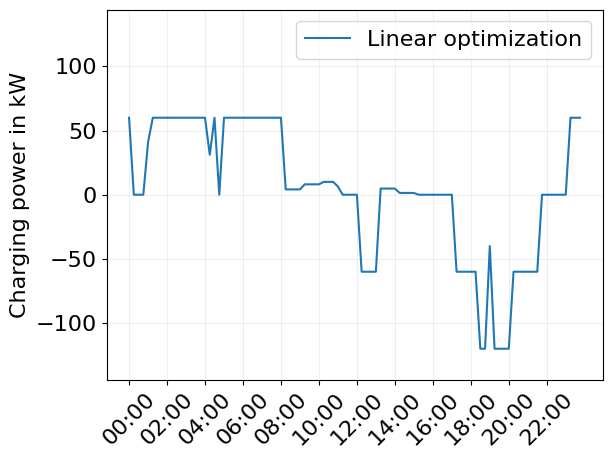

In [30]:
lp.plot_benchmark(lp_log)

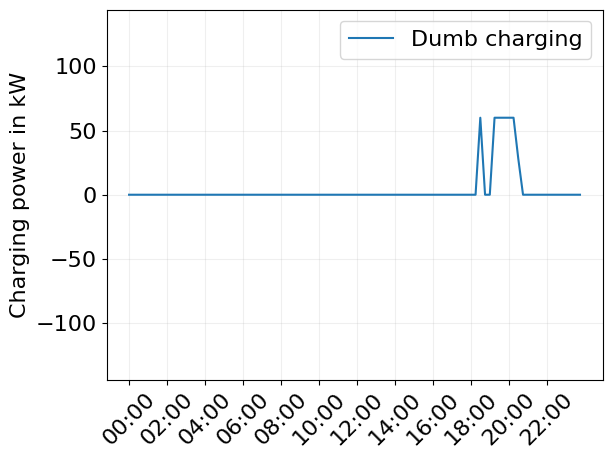

In [31]:
uncontrolled_charging.plot_benchmark(uc_log)

This showcases some evaluation methods that have already been written for easy comparison
You can, of course, create new analytics from the log dataframes

RL reward: -76.73592583670715
DC reward: -104.09889358235887
RL cashflow: -9.406909757249428
DC cashflow: -11.963635653197544
                     Category  RL-based charging  benchmark charging
0                      Reward         -76.735926         -104.098894
1                    Cashflow          -9.406910          -11.963636
2  Average degradation per EV           0.000700            0.000000
3                 Overloading           0.000000            0.000000
4               SOC violation           0.000000            0.000000
5                # Violations           0.000000            0.000000
6                         SOH           0.999300            1.000000


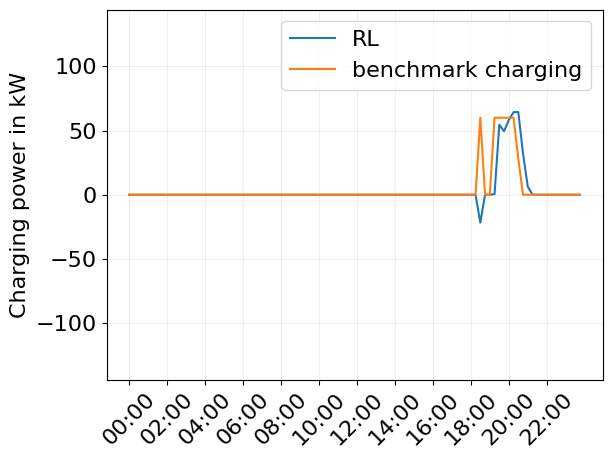

RL reward: -76.73592583670715
DC reward: 25.198911856275586
RL cashflow: -9.406909757249428
DC cashflow: 11.852092928801827
                     Category  RL-based charging  benchmark charging
0                      Reward         -76.735926           25.198912
1                    Cashflow          -9.406910           11.852093
2  Average degradation per EV           0.000700            0.000720
3                 Overloading           0.000000            0.000000
4               SOC violation           0.000000            0.050020
5                # Violations           0.000000            1.000000
6                         SOH           0.999300            0.999280


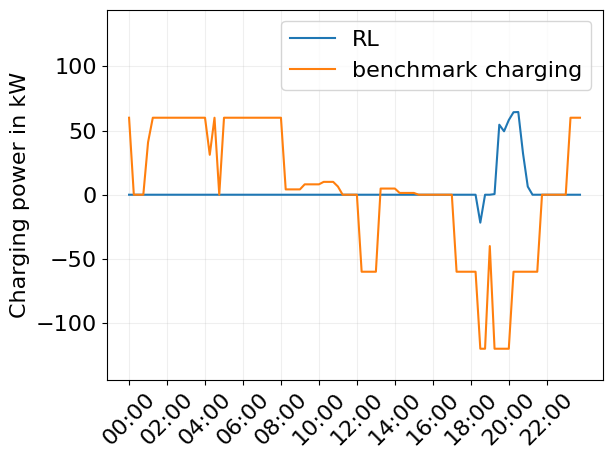

/home/enzo/Desktop/FleetRL/fleetrl/agent_eval/basic_evaluation.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels()[0:12])[0:12]


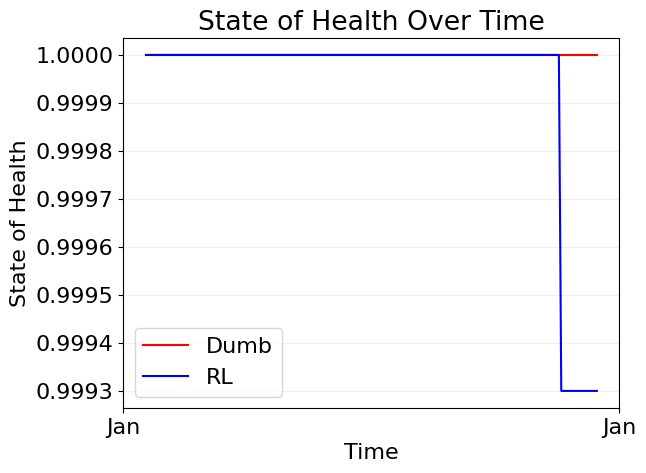

/home/enzo/Desktop/FleetRL/fleetrl/agent_eval/basic_evaluation.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels()[0:12])[0:12]


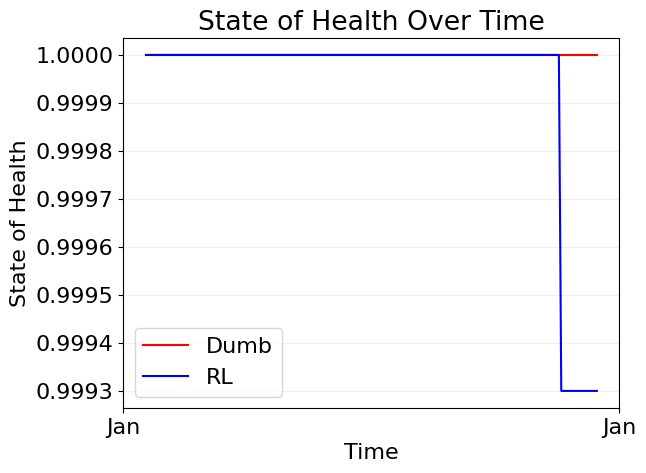

/home/enzo/Desktop/FleetRL/fleetrl/agent_eval/basic_evaluation.py:201: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels()[0:12])[0:12]


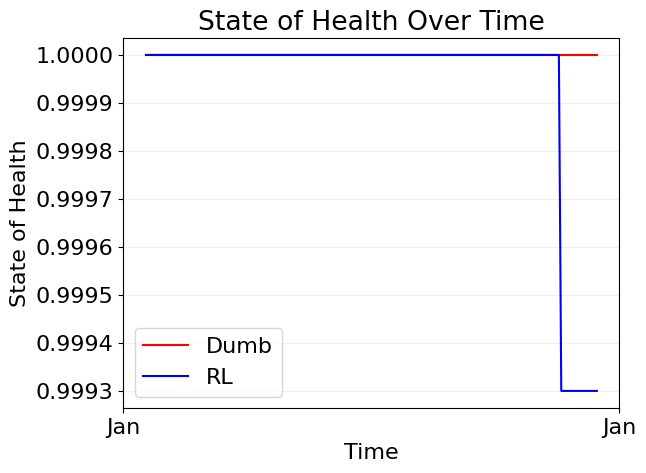

No violations found.


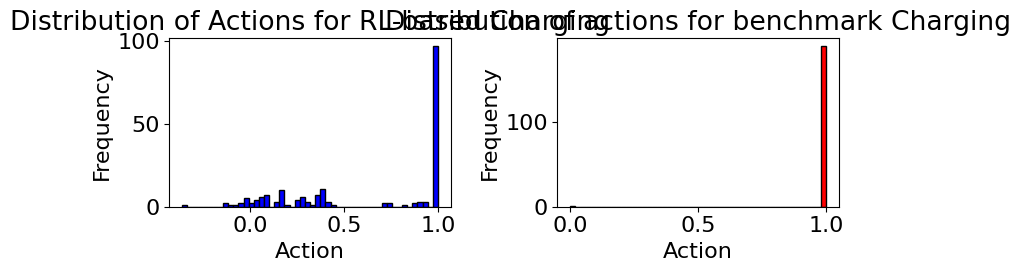

In [32]:
eval.compare(rl_log=rl_log, benchmark_log=uc_log)
eval.compare(rl_log=rl_log, benchmark_log=lp_log)
eval.plot_soh(rl_log=rl_log, benchmark_log=uc_log)
eval.plot_soh(rl_log=rl_log, benchmark_log=dist_log)
eval.plot_soh(rl_log=rl_log, benchmark_log=night_log)
eval.plot_violations(rl_log=rl_log, benchmark_log=uc_log)
eval.plot_action_dist(rl_log=rl_log, benchmark_log=uc_log)

The detailed plot shows what is happening during certain days of the simulation. You can add as many benchmark logs as you have compiled, the figure will automatically adjust based on number of EVs, number of logs, etc.

In [42]:
detailed_fig = eval.plot_detailed_actions(start_date="2021-01-02 19:00", 
                                          end_date="2021-01-04 18:45",
                                          rl_log=rl_log,
                                          uc_log=uc_log,
                                          dist_log=dist_log,
                                          night_log=night_log)

detailed_fig.show()